# 使用国内资产复现bender的论文 -- 使用pca因子

In [6]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm
from sklearn.decomposition import PCA

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

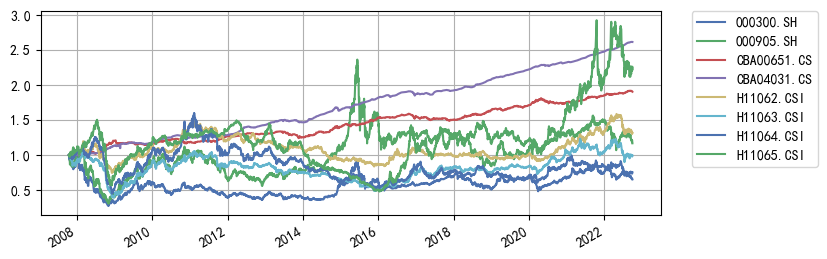

In [7]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')
(asset_data_raw.dropna()/asset_data_raw.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [8]:
# 回测参数
date_range = [datetime(2018,1,1), datetime(2021,12,31)]
frequency = 22 
look_back = 252*3

## 1. 计算fmp

In [9]:
class pcaFmpStrategy(Strategy):
    def __init__(self, n_components=5, i_component=0):
        super().__init__()
        self._n_components = n_components
        self._i_component = i_component

    def getPcaFactorReturns(self, asset_data):
        asset_data = asset_data.rolling(22).mean().dropna()
        asset_return = asset_data.pct_change().fillna(0)

        pca=PCA(n_components=self._n_components)  
        asset_return_pca = pca.fit_transform(asset_return)
        asset_return_pca = pd.DataFrame(asset_return_pca)

        asset_return_pca.index = asset_data.index
        asset_return_pca.columns = ['factor_{}'.format(i) for i in range(asset_return_pca.shape[1])]

        return asset_return_pca

    def run(self, id_date, asset_data):
        pca_factor_returns = self.getPcaFactorReturns(asset_data)
        asset_returns = asset_data.pct_change().reindex(pca_factor_returns.index)
        exposure = getFatorExposureFrame(asset_returns, pca_factor_returns, norm=False).iloc[:, self._i_component]

        if exposure.sum() < 0:
            exposure *= -1


        # print(exposure)
        # sys.exit(1)
        return exposure


In [10]:
fmp_values = pd.DataFrame()
fmp_weights = {}

for i in range(5):
    column_name = 'factor_{}'.format(i)
    fmp_return_backtest = BacktestManager(
            pcaFmpStrategy(i_component=i), 
            asset_data_raw, 
            date_range = date_range, 
            frequency = frequency, 
            look_back = look_back, 
        )
    fmp_return_backtest.run()
    fmp_values[column_name] = fmp_return_backtest.getHistoricalValue(scale=True)
    fmp_weights[column_name] = pd.DataFrame(columns=asset_data_raw.columns)
    for id_date, weights in fmp_return_backtest._historcial_weights.items():
        fmp_weights[column_name].loc[id_date] = weights.reindex(fmp_weights[column_name].columns)

100%|██████████| 973/973 [00:08<00:00, 114.08it/s]


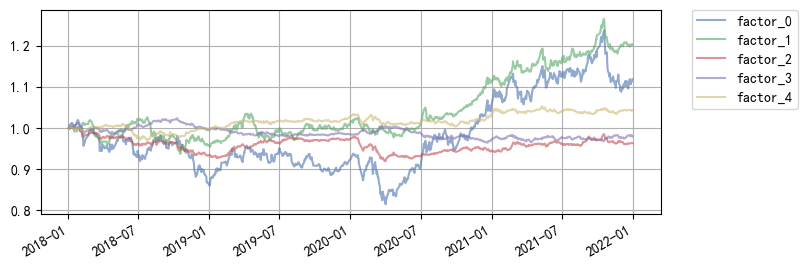

In [11]:
fmp_values.plot(figsize=(8,3), grid=True, alpha=0.6)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

## 2. 预测资产收益

In [12]:
# 使用历史收益率作为fmp收益率预测
fmp_lookback = 252 * 1
tmp_fmp_returns = fmp_values.loc[:id_date].iloc[-fmp_lookback:].pct_change().fillna(0)

In [13]:
class AssetAlphaStrategy(Strategy):
    def __init__(self, fmp_value):
        super().__init__()
        self._asset_alpha = pd.DataFrame(columns=list(asset_data_raw.columns))
        self._opt_fp_df = pd.DataFrame(columns=list(fmp_value))
        self._fmp_returns = fmp_value.pct_change()

    def run(self, id_date, asset_data):
        opt_fp = optimalFactorPortfolio(self._fmp_returns.loc[:id_date].iloc[-fmp_lookback:])
        self._opt_fp_df.loc[id_date] = list(opt_fp.values[0])
        tmp_fmp_weights = pd.DataFrame({factor: v.loc[id_date].reindex(list(asset_data.columns)) for factor,v in fmp_weights.items()})
        tmp_asset_returns = asset_data_raw.pct_change().loc[:id_date].iloc[-fmp_lookback:]
        self._asset_alpha.loc[id_date] = list(getAssetExpectedReturns(opt_fp, tmp_fmp_weights, tmp_asset_returns).values[0])
        # print(list(getAssetExpectedReturns(opt_fp, tmp_fmp_weights, tmp_asset_returns).values[0]))
        # sys.exit(1)
        return pd.Series([0]*asset_data.shape[1], index=asset_data.columns)
        

In [14]:
date_range = [datetime(2019,1,31), datetime(2021,12,31)]
aa_backtest = BacktestManager(
    AssetAlphaStrategy(fmp_values), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
aa_backtest.run()

  5%|▍         | 35/709 [00:00<00:03, 174.25it/s]

2019-01-31 00:00:00: skip
2019-03-11 00:00:00: skip


 10%|█         | 71/709 [00:00<00:04, 158.58it/s]

2019-04-11 00:00:00: skip
2019-05-16 00:00:00: skip


 16%|█▌        | 111/709 [00:00<00:03, 175.10it/s]

2019-06-18 00:00:00: skip
2019-07-18 00:00:00: skip


 23%|██▎       | 163/709 [00:01<00:03, 144.00it/s]

2019-08-19 00:00:00: skip
2019-09-19 00:00:00: skip


 28%|██▊       | 199/709 [00:01<00:03, 143.99it/s]

2019-10-28 00:00:00: skip
2019-11-27 00:00:00: skip


 34%|███▍      | 243/709 [00:01<00:02, 172.44it/s]

2019-12-27 00:00:00: skip
2020-02-06 00:00:00: skip
2020-03-09 00:00:00: skip


 44%|████▎     | 309/709 [00:01<00:02, 187.50it/s]

2020-04-09 00:00:00: skip
2020-05-14 00:00:00: skip


 50%|████▉     | 353/709 [00:02<00:01, 186.20it/s]

2020-06-15 00:00:00: skip
2020-07-17 00:00:00: skip


 56%|█████▌    | 398/709 [00:02<00:01, 195.92it/s]

2020-08-18 00:00:00: skip
2020-09-17 00:00:00: skip


 62%|██████▏   | 441/709 [00:02<00:01, 187.30it/s]

2020-10-27 00:00:00: skip
2020-11-26 00:00:00: skip


 70%|███████   | 498/709 [00:02<00:01, 179.77it/s]

2020-12-28 00:00:00: skip
2021-01-28 00:00:00: skip


 75%|███████▌  | 535/709 [00:03<00:01, 152.30it/s]

2021-03-08 00:00:00: skip
2021-04-08 00:00:00: skip


 80%|███████▉  | 567/709 [00:03<00:01, 125.57it/s]

2021-05-13 00:00:00: skip
2021-06-15 00:00:00: skip


 87%|████████▋ | 617/709 [00:03<00:00, 137.16it/s]

2021-07-15 00:00:00: skip
2021-08-16 00:00:00: skip


 93%|█████████▎| 661/709 [00:04<00:00, 154.61it/s]

2021-09-15 00:00:00: skip
2021-10-26 00:00:00: skip


100%|██████████| 709/709 [00:04<00:00, 164.03it/s]

2021-11-25 00:00:00: skip
2021-12-27 00:00:00: skip


In [15]:
# asset alpha
aa_backtest._strategy._asset_alpha

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
2019-01-31,-0.385933,-0.420398,0.019910,0.002867,-0.042301,-0.186521,-0.239522,-0.108731
2019-03-11,0.308352,0.357749,-0.010713,-0.001556,-0.019763,0.044172,0.121538,-0.021215
2019-04-11,0.626684,0.702337,-0.022717,-0.001928,-0.012090,0.131479,0.197478,0.075020
2019-05-16,0.093695,0.116652,-0.005160,-0.000319,0.051785,0.026181,0.060069,0.001573
2019-06-18,-0.045984,-0.043085,0.002030,0.000152,0.005560,-0.007987,-0.020738,-0.036812
2019-07-18,-0.058147,-0.091844,-0.000838,0.001217,0.016749,0.140987,0.083228,0.271588
2019-08-19,0.026863,0.023698,-0.001685,0.000006,0.008147,0.064768,-0.012471,0.056218
2019-09-19,0.168723,0.191686,-0.007794,-0.001109,0.023614,0.085281,0.020063,0.006685
2019-10-28,0.531210,0.609489,-0.022116,-0.001594,0.048113,0.183501,0.120299,0.132678
2019-11-27,0.230621,0.238995,-0.009938,-0.000502,0.023920,0.131623,0.064178,0.199702


In [16]:
aa_backtest._strategy._asset_alpha.to_csv(os.path.join(this_path, '../data/assets/asset_alpha_pca.csv'))